# Проектная практика

## Задача

Мониторинг экосистемы через IT-решения.

## Проблема

Окружающая среда подвергается постоянным изменениям под влиянием естественных факторов и человеческой деятельности. Экологам, исследователям и властям необходимы надёжные данные для мониторинга экосистем, однако традиционные методы сбора данных трудоёмки и подвержены ошибкам.

### Решение

Создание IT-системы, которая:

- использует данные визуального конторля с дрона;
- применяет предобученную модели CV для классификации мусора на данных визуального контроля;
- классифицирует данные для поддержки принятия решений.

In [1]:
! pip install -r requirements.txt

In [2]:
import os
import matplotlib.pyplot as plt

import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from PIL import Image
from torch.nn import Module, Linear, CrossEntropyLoss
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.transforms import Compose, Resize, ToTensor, Normalize

import numpy as np
np.random.seed(42)

В проекте используется копия [набора данных](https://www.kaggle.com/datasets/mvanshika/drone-garbage-detection/data), который представляет собой множество различных классифицированных фотографий мусора на песчаном пляже, снятых с использованием БПЛА, и разбитых на 3 подмножества: тренировочное, валидационное и тестовое.

В наборе данных представлены следующие типы мусора:
- стекло (glass) 
- пластиковые бутылки и одноразовые стаканчики (plastic_bottle_takeaway_cup)
- пищевая упаковка (retort_pouch)
- ланч-боксы (take_away_container)
- жестяные и алюминиевые банки (tin_aluminium_cans)

Изображения представлены в формате JPEG с названиями, указывающими на исходное видео и номер кадра, для упрощения отслеживание и проверки контекста каждого изображения.
Пример: VID_20230723_101947_0036_MP4-0_jpg.rf.9d22e3308027a20ddc97aedf6d5ac997.jpg обозначает кадр, извлеченный из видео, записанного 23 июля 2023 года, с конкретными идентификаторами кадра и источника изображения.

Проведём разведывательный анализ данных и визуализируем встречаемость классов мусора по подмножествам.

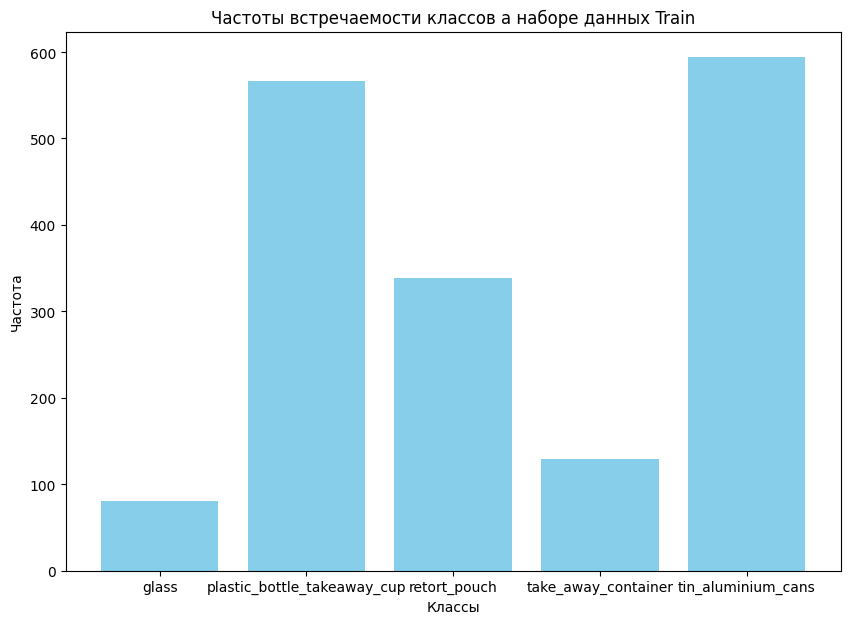

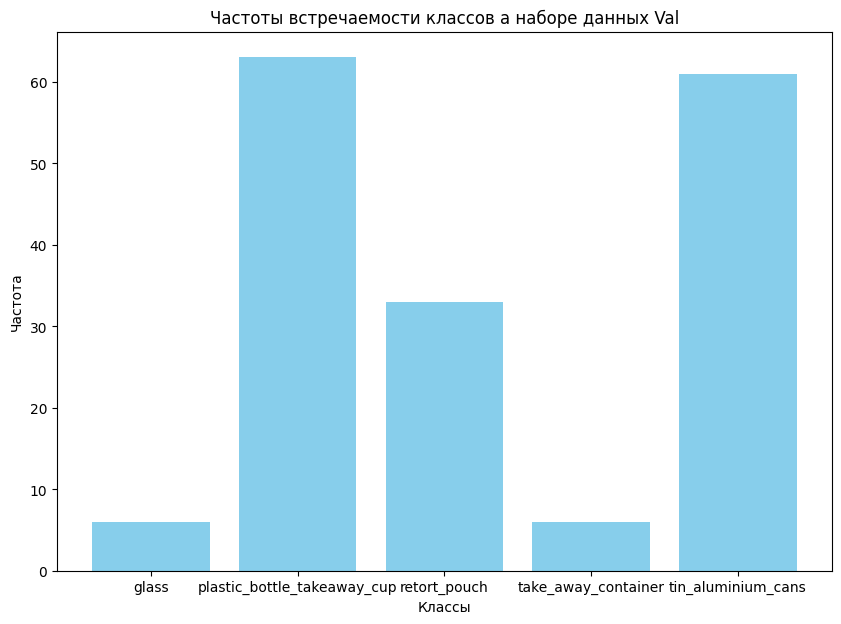

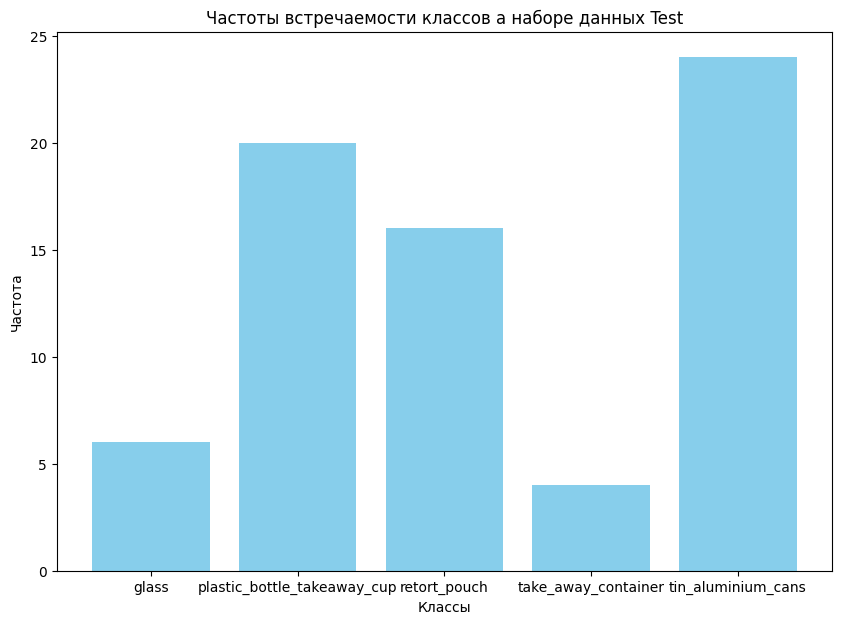

In [3]:
DATA_DIR = './datasets/'
MODEL_DIR = './models/'
CLASSES = ['glass', 'plastic_bottle_takeaway_cup', 'retort_pouch', 'take_away_container', 'tin_aluminium_cans']
SETS = ['train', 'val', 'test']

def eda(data_dir):
    data_counts = {dataset_type: {cls: 0 for cls in CLASSES} for dataset_type in SETS}

    for dataset_type in SETS:
        for cls in CLASSES:
            cls_path = os.path.join(data_dir, dataset_type, cls)
            if os.path.exists(cls_path):
                data_counts[dataset_type][cls] = len(os.listdir(cls_path))
    
    # Plotting the distribution
    for dataset_type in SETS:
        plt.figure(figsize=(10, 7))
        plt.bar(data_counts[dataset_type].keys(), data_counts[dataset_type].values(), color='skyblue')
        plt.xlabel('Классы')
        plt.ylabel('Частота')
        plt.title(f'Частоты встречаемости классов а наборе данных {dataset_type.capitalize()}')
        plt.show()

eda(DATA_DIR)


Все классы представлены во всех подмножествах. Частоты встречаемости классов по подмножествам сходны. Можно использовать данные для тренировки модели.

Создадим модель и наборы данных.

In [4]:
torch.backends.cudnn.benchmark = True
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Модель использует для работы: {DEVICE}")

class DataSetItem(Dataset): # имплементация стандартного класса для набора данных
    def __init__(self, images, transform):
        self.images = images
        self.transform = transform

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        img_label, img_path = self.images[index]
        raw_img = Image.open(img_path).convert("RGB")
        return CLASSES.index(img_label), self.transform(raw_img) if self.transform else raw_img

class DataClassifier(Module): # имплементация стандартного класса для модели
    def __init__(self, num_classes):
        super(DataClassifier, self).__init__()
        self.model = resnet18(weights=ResNet18_Weights.DEFAULT) # используем предобученную модель ResNet18
        for param in self.model.parameters(): # отключаем обучение внутренних слоёв
            param.requires_grad = False
        self.model.fc = Linear(self.model.fc.in_features, num_classes) # указываем слой классификатора для обучения

    def forward(self, X): 
        return self.model(X)

def gen_data_loader(root_dir, transform=None, batch_size=32, shuffle=False): # создание экземпляра набора данных
    def get_image_path(class_dir):
        return [os.path.join(class_dir, img_name) for img_name in os.listdir(class_dir)]

    images = sum([[(label, img_path) for img_path in img_paths] 
                  for label, img_paths in [(label, get_image_path(os.path.join(root_dir, label))) 
                                           for label in CLASSES]], 
                 [])
    return DataLoader(DataSetItem(images, transform), batch_size=batch_size, shuffle=shuffle, num_workers=4, pin_memory=True)

def gen_classifier_model(num_classes, lr=0.001): # создание пары экземпляра модели CV и оптимизатора экземпляра
    model = DataClassifier(num_classes).to(DEVICE, non_blocking=True)
    return model, Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)    
    
transform = Compose([Resize((224, 224)), ToTensor(), Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]) # правила трансформации изображений

train_loader = gen_data_loader(f'{DATA_DIR}/train', transform, shuffle=True) # создание тренировочного набора данных
val_loader = gen_data_loader(f'{DATA_DIR}/val', transform) # создание валидационного набора данных
test_loader = gen_data_loader(f'{DATA_DIR}/test', transform) # создание тестового набора данных

model, optimizer = gen_classifier_model(len(CLASSES)) # создание пары модель CV и оптимизатор

Модель использует для работы: cpu


Проведём тренировку модели на тренировочных и валидационных данных.

In [5]:
def train(model, optimizer, loader, criterion): # тренировка одной эпохи модели
    model.train()
    current_loss = 0.0
    current_corrects = 0

    for raw_labels, raw_inputs in loader: # проводим тренировку для всех данных и классов в наборе
        inputs = raw_inputs.to(DEVICE, non_blocking=True)
        labels = raw_labels.to(DEVICE, non_blocking=True)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        loss.backward()
        optimizer.step()

        current_loss += loss.item() * inputs.size(0)
        current_corrects += torch.sum(preds == labels.data) 
    
    return model, current_loss/len(loader.dataset), current_corrects.double()/len(loader.dataset) # возвращаем тренированную модель и метрики

def eval(model, loader, criterion=None): # валидация модели
    model.eval()
    current_loss = 0.0
    current_corrects = 0
    
    with torch.no_grad():
        for raw_labels, raw_inputs in loader: # проводим предсказания для всех данных и классов в наборе
            inputs = raw_inputs.to(DEVICE, non_blocking=True)
            labels = raw_labels.to(DEVICE, non_blocking=True)
            outputs = model(inputs)
            if criterion:
                loss = criterion(outputs, labels)
                current_loss += loss.item() * inputs.size(0)
            
            _, preds = torch.max(outputs, 1)
            current_corrects += torch.sum(preds == labels.data)

    return model, current_loss/len(loader.dataset) if criterion else None, current_corrects.double()/len(loader.dataset) # возвращаем валидируемую модель и метрики

def train_model(model, criterion, optimizer, train_loader, eval_loader, num_epochs=25): # тренировка модели с валидацией для каждой эпохи
    for epoch in range(num_epochs):
        model, epoch_loss, epoch_acc = train(model, optimizer, train_loader, criterion)
        model, eval_loss, eval_acc = eval(model, eval_loader, criterion)
        print(f'Epoch {epoch}/{num_epochs - 1}, Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, Eval Loss: {eval_loss:.4f}, Eval Acc: {eval_acc:.4f}')
    
    return model

model = train_model(model, CrossEntropyLoss(), optimizer, train_loader, val_loader, num_epochs=10) # тренируем модель

/home/wsl/miphi/project_practice/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch 0/9, Train Loss: 1.0095, Train Acc: 0.6170, Eval Loss: 0.6276, Eval Acc: 0.7870
Epoch 1/9, Train Loss: 0.5622, Train Acc: 0.8228, Eval Loss: 0.4651, Eval Acc: 0.8343
Epoch 2/9, Train Loss: 0.4300, Train Acc: 0.8719, Eval Loss: 0.3910, Eval Acc: 0.8521
Epoch 3/9, Train Loss: 0.3513, Train Acc: 0.8959, Eval Loss: 0.3379, Eval Acc: 0.8698
Epoch 4/9, Train Loss: 0.3263, Train Acc: 0.9000, Eval Loss: 0.3013, Eval Acc: 0.8935
Epoch 5/9, Train Loss: 0.2992, Train Acc: 0.8965, Eval Loss: 0.2881, Eval Acc: 0.8817
Epoch 6/9, Train Loss: 0.2597, Train Acc: 0.9240, Eval Loss: 0.2687, Eval Acc: 0.8876
Epoch 7/9, Train Loss: 0.2384, Train Acc: 0.9304, Eval Loss: 0.2623, Eval Acc: 0.8994
Epoch 8/9, Train Loss: 0.2201, Train Acc: 0.9310, Eval Loss: 0.2531, Eval Acc: 0.8935
Epoch 9/9, Train Loss: 0.2135, Train Acc: 0.9409, Eval Loss: 0.2666, Eval Acc: 0.9172


## Результат

Проведём анализ метрики точности на тестовых данных

In [6]:
model, _, test_acc = eval(model, test_loader) # получаем метрику точности для тренировочного набора данных
print(f'Точность на тестовом наборе данных: {test_acc:.4f}')

Точность на тестовом наборе данных: 0.9857


Реализуем функцию предсказания для модели и получим предсказания для тестового набора данных.

In [7]:
def predict(model, loader): # функция предсказания модели
    model.eval()
    all_labels = [] # истинный класс
    all_preds = [] # предсказанный класс

    with torch.no_grad():
        for raw_labels, raw_inputs in loader: # предсказываем результат для всех классов и данных набора
            inputs = raw_inputs.to(DEVICE, non_blocking=True)
            labels = raw_labels.to(DEVICE, non_blocking=True)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_labels.append(labels)
            all_preds.append(preds)

    return torch.cat(all_labels).cpu().numpy(), torch.cat(all_preds).cpu().numpy()

y_true, y_pred = predict(model, test_loader)

Построим матрицу ошибок модели и её нормированный вариант, используя предсказанные классы и истинные значения.

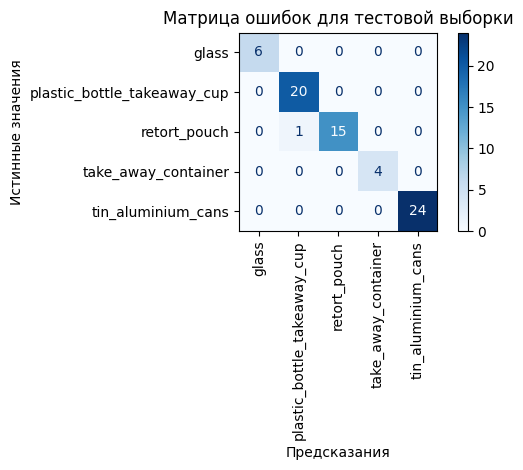

In [8]:
cm = confusion_matrix(y_true, y_pred) # создание матрицы ошибок

disp = ConfusionMatrixDisplay(confusion_matrix=cm, # визуализация матрицы ошибок
                              display_labels=CLASSES)
disp.plot(cmap="Blues", xticks_rotation=90)
plt.title("Матрица ошибок для тестовой выборки")
plt.xlabel('Предсказания')
plt.ylabel('Истинные значения')
plt.tight_layout()
plt.show()

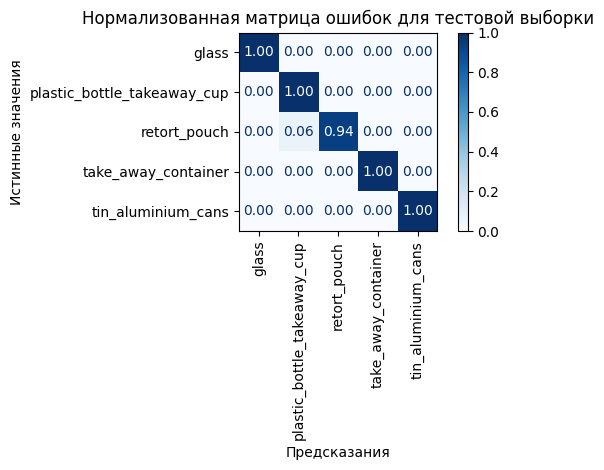

In [9]:
cm_norm = confusion_matrix(y_true, y_pred, normalize='true') # создание нормированной матрицы ошибок

disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, # визуализация нормированной матрицы ошибок
                              display_labels=CLASSES)
disp.plot(cmap="Blues", xticks_rotation=90, values_format=".2f")
plt.title("Нормализованная матрица ошибок для тестовой выборки")
plt.xlabel('Предсказания')
plt.ylabel('Истинные значения')
plt.tight_layout()
plt.show()


In [10]:
print(classification_report(y_true, y_pred, target_names=CLASSES)) # получение метрик precision, recall, f1-score по классам

                             precision    recall  f1-score   support

                      glass       1.00      1.00      1.00         6
plastic_bottle_takeaway_cup       0.95      1.00      0.98        20
               retort_pouch       1.00      0.94      0.97        16
        take_away_container       1.00      1.00      1.00         4
         tin_aluminium_cans       1.00      1.00      1.00        24

                   accuracy                           0.99        70
                  macro avg       0.99      0.99      0.99        70
               weighted avg       0.99      0.99      0.99        70



Визуализируем `num_images` элементов с предсказаниями модели и истинным классом объектов.

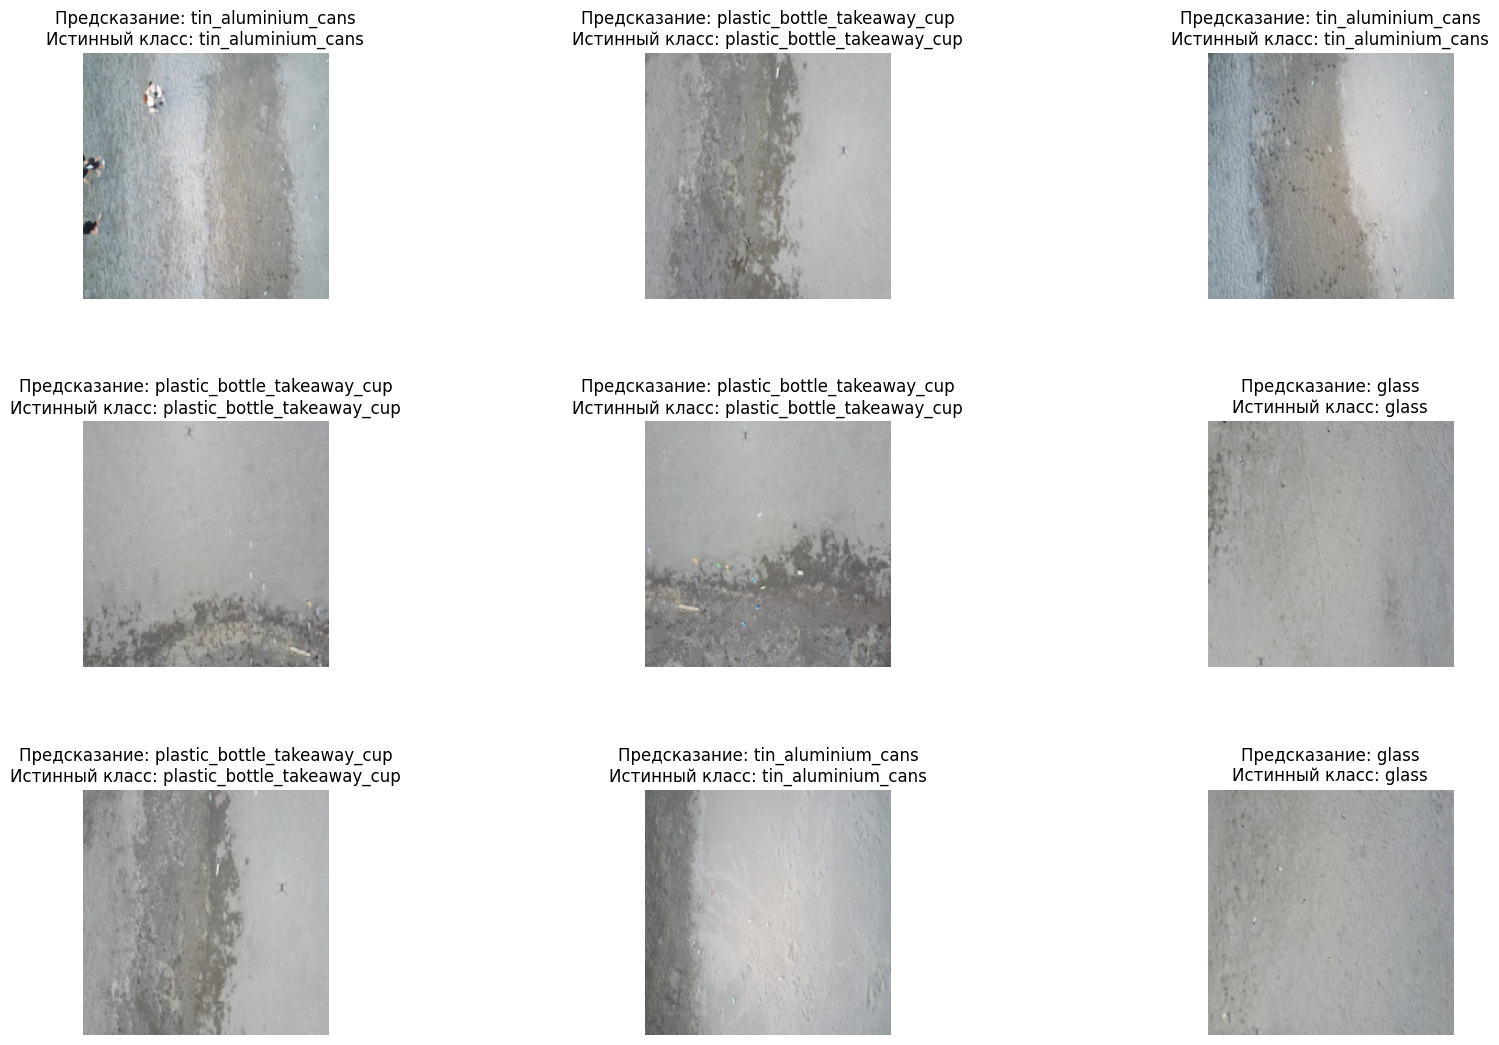

In [11]:
def visualize_predictions(model, dataset, num_images=9):
    model.eval()
    fig = plt.figure(figsize=(15, 15))
    fig.subplots_adjust(left=0, right=1, top=0.9, bottom=0, hspace=0.5, wspace=0.5)
    
    with torch.no_grad():
        for i, idx in enumerate(np.random.choice(range(len(dataset)), num_images)):
            labels, inputs = dataset[idx]
            inputs = inputs.unsqueeze(0).to(DEVICE)
            labels = labels

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            ax = plt.subplot(4, 3, i+1)
            ax.axis('off')
            ax.set_title(f'Предсказание: {CLASSES[preds[0]]}\nИстинный класс: {CLASSES[labels]}')

            img = inputs[0].cpu().permute(1, 2, 0) * torch.tensor([0.229, 0.224, 0.225]) + torch.tensor([0.485, 0.456, 0.406])
            plt.imshow(img.clamp(0, 1))

    plt.show()

visualize_predictions(model, test_loader.dataset)

Сохраним тренированную модель для дальнейшего использования.

In [12]:
os.makedirs(MODEL_DIR, exist_ok=True)
torch.save(model.state_dict(), os.path.join(MODEL_DIR, 'resnet18_eco.pth'))

Загрузим сохранённую модель и проверим её работоспособность на тестовом наборе данных.

/home/wsl/miphi/project_practice/.venv/lib/python3.12/site-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Точность на тестовом наборе данных: 0.9857


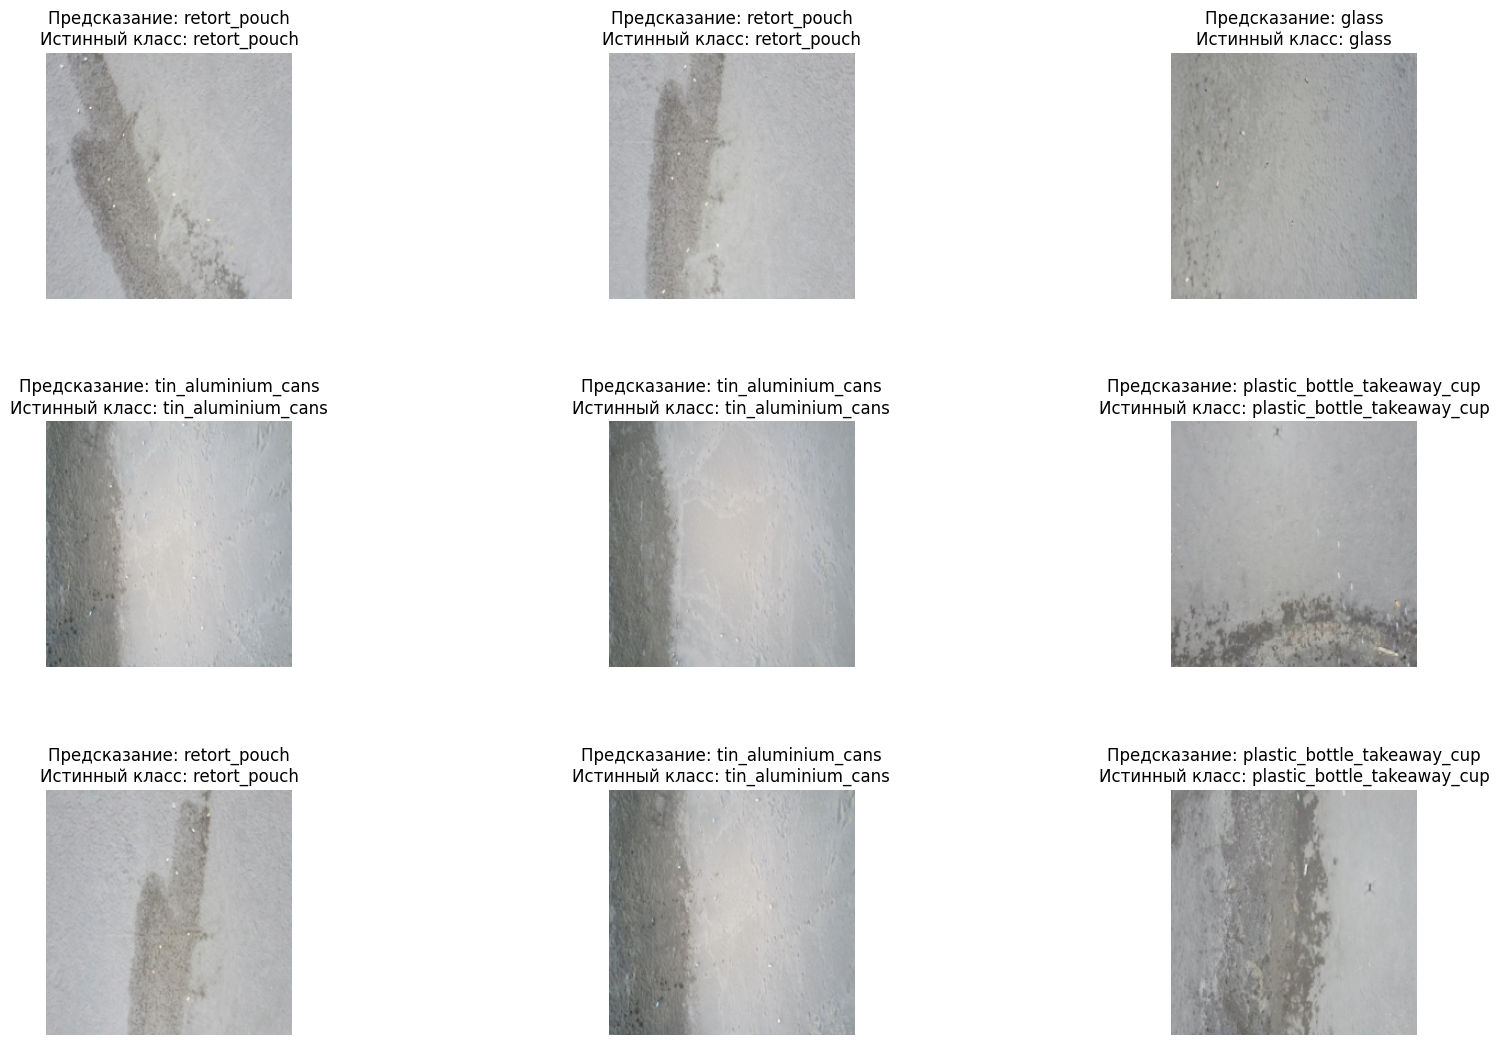

In [13]:
test_model = DataClassifier(len(CLASSES))

state_dict = torch.load(os.path.join(MODEL_DIR, 'resnet18_eco.pth'), map_location=DEVICE)
test_model.load_state_dict(state_dict)

test_model, _, test_acc = eval(test_model, test_loader) # получаем метрику точности для тренировочного набора данных
print(f'Точность на тестовом наборе данных: {test_acc:.4f}')
visualize_predictions(test_model, test_loader.dataset)

Работоспособность сохранённой модели подтверждена.